# EX1: Linear regression
 We first consider a simple linear regression model with a Gaussian likelihood. We compute the evidence for the model first with nested sampling, and then with the fourier integration method.

In [84]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import os, shutil
import numpy as np
import warnings
from matplotlib import pyplot as plt
import bilby
import logging
from funnel.plotting import plot_fi_evidence_results
from funnel.fi_core import get_fi_lnz_list

CLEAN = True
OUTDIR = 'out_line'

if os.path.exists(OUTDIR) and CLEAN:
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)

np.random.seed(42)
warnings.filterwarnings("ignore")
logging.getLogger('bilby').setLevel(logging.CRITICAL)

## Generate some data

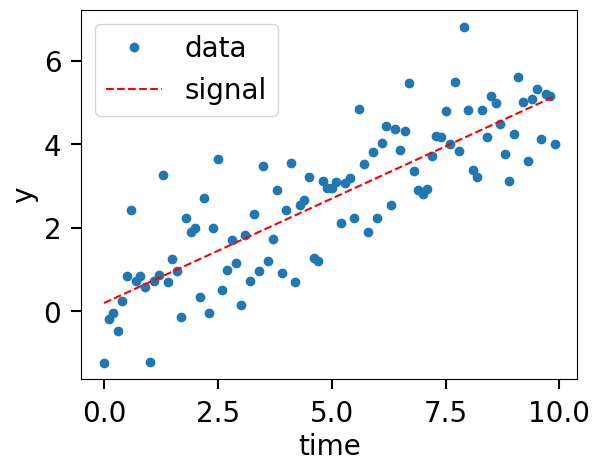

In [74]:
# First, we define our "signal model", in this case a simple linear function
def model(time, m, c):
    return time * m + c


# Now we define the injection parameters which we make simulated data with
injection_parameters = dict(m=0.5, c=0.2)

sampling_frequency = 10
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
sigma = np.random.normal(1, 0.01, N)
data = model(time, **injection_parameters) + np.random.normal(0, sigma, N)

# We quickly plot the data to check it looks sensible
fig, ax = plt.subplots()
ax.plot(time, data, "o", label="data")
ax.plot(time, model(time, **injection_parameters), "--r", label="signal")
ax.set_xlabel("time")
ax.set_ylabel("y")
ax.legend();


## Nested sampling LnZ Calculation

In [75]:
class GaussianLikelihood(bilby.likelihood.Analytical1DLikelihood):
    def __init__(self, x, y, func, sigma=None, **kwargs):
        super(GaussianLikelihood, self).__init__(x=x, y=y, func=func, **kwargs)
        self.sigma = sigma

    def log_likelihood(self):
        return np.sum(- (self.residual / self.sigma) ** 2 / 2 - np.log(2 * np.pi * self.sigma ** 2) / 2)

    def noise_log_likelihood(self):
        return np.sum(- (self.y / self.sigma) ** 2 / 2 - np.log(2 * np.pi * self.sigma ** 2) / 2)


likelihood = GaussianLikelihood(time, data, model, sigma)

priors = bilby.core.prior.PriorDict(dict(
    m=bilby.core.prior.Uniform(0, 5, "m"),
    c=bilby.core.prior.Uniform(-2, 2, "c")
))

label = 'line'
res_fn = f"{OUTDIR}/{label}_result.json"

if os.path.exists(res_fn):
    result = bilby.read_in_result(res_fn)

else:
    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=1500,
        outdir=OUTDIR,
        label=label,
        injection_parameters=injection_parameters,
    )
lnz, lnz_err = result.log_evidence, result.log_evidence_err
print(f"LnZ: {lnz:.2f}+/-{lnz_err:.2f}")
print(f"lnBF: {result.log_bayes_factor}")
result.posterior.head()

1it [00:00, ?it/s]


LnZ: -143.80+/-0.08
lnBF: 462.81213009525925


,m,c,log_likelihood,log_prior
0,0.357726,1.041932,460.450103,-2.995732
1,0.611756,-0.560525,462.124596,-2.995732
2,0.548062,-0.373219,462.476530,-2.995732
3,0.532804,0.427149,462.706528,-2.995732
4,0.538333,-0.322802,462.891511,-2.995732


In [76]:
class GaussianLikelihoodNoNoiseLikelihood(bilby.likelihood.Analytical1DLikelihood):
    def __init__(self, x, y, func, sigma=None, **kwargs):
        super(GaussianLikelihoodNoNoiseLikelihood, self).__init__(x=x, y=y, func=func, **kwargs)
        self.sigma = sigma

    def log_likelihood(self):
        return np.sum(- (self.residual / self.sigma) ** 2 / 2 - np.log(2 * np.pi * self.sigma ** 2) / 2)

likelihood = GaussianLikelihoodNoNoiseLikelihood(time, data, model, sigma)

priors = bilby.core.prior.PriorDict(dict(
    m=bilby.core.prior.Uniform(0, 5, "m"),
    c=bilby.core.prior.Uniform(-2, 2, "c")
))

label = 'line_wo_noise'
res_fn = f"{OUTDIR}/{label}_result.json"
if os.path.exists(res_fn):
    result = bilby.read_in_result(res_fn)
else:
    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=1500,
        outdir=OUTDIR,
        label=label,
        injection_parameters=injection_parameters,
    )
lnz, lnz_err = result.log_evidence, result.log_evidence_err
print(f"LnZ: {lnz:.2f}+/-{lnz_err:.2f}")
print(f"lnBF: {result.log_bayes_factor}")
result.posterior.head()

1it [00:00, ?it/s]


LnZ: -143.65+/-0.08
lnBF: nan


,m,c,log_likelihood,log_prior
0,0.622600,-0.653672,-146.520300,-2.995732
1,0.441560,0.881200,-145.141573,-2.995732
2,0.518018,-0.263875,-144.852101,-2.995732
3,0.505545,-0.197196,-144.554968,-2.995732
4,0.516669,0.530921,-144.507963,-2.995732


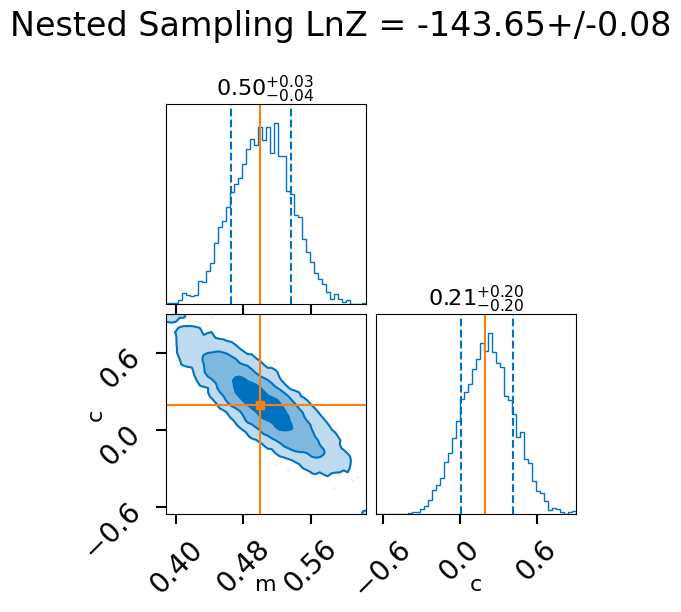

In [77]:
fig = result.plot_corner()
fig.suptitle(f"Nested Sampling LnZ = {lnz:.2f}+/-{lnz_err:.2f}", y=1.1);
fig

NOTE: bilby stores the 'likelihood-ratio' in the `log-likelihood` column when the `noise_log_likelihood` function is defined (compare the posteriors from the above two examples).

## FI LnZ calculation

In [86]:
lnz_file = f"{OUTDIR}/lnz.npz"
lnzs, r_vals = get_fi_lnz_list(result.posterior, num_ref_params=100, cache_fn=lnz_file)

|funnel|INFO| Calculating FI LnZ with 100 reference points and a posterior of size: (4114, 2) 


FI LnZ:   0%|          | 0/100 [00:00<?, ?it/s]

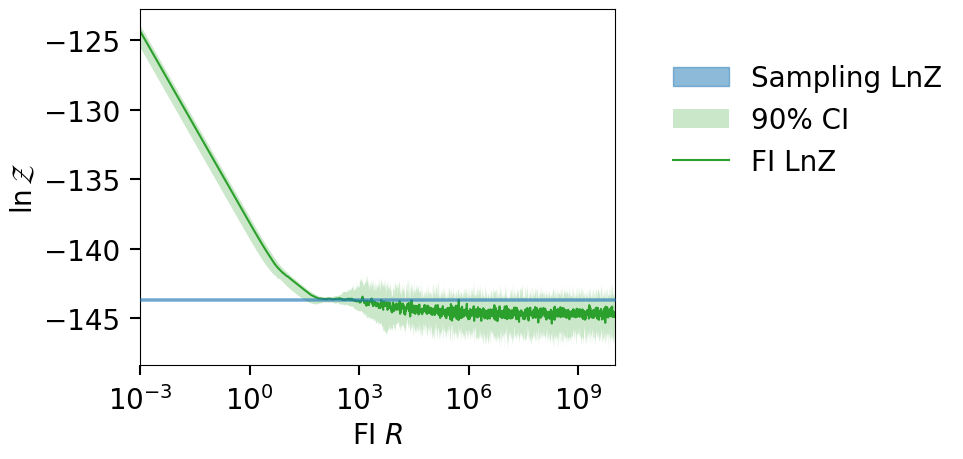

In [87]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals, sampling_lnz=[lnz + lnz_err, lnz - lnz_err], )

fig = plot_fi_evidence_results(**plt_kwgs)
fig.tight_layout()

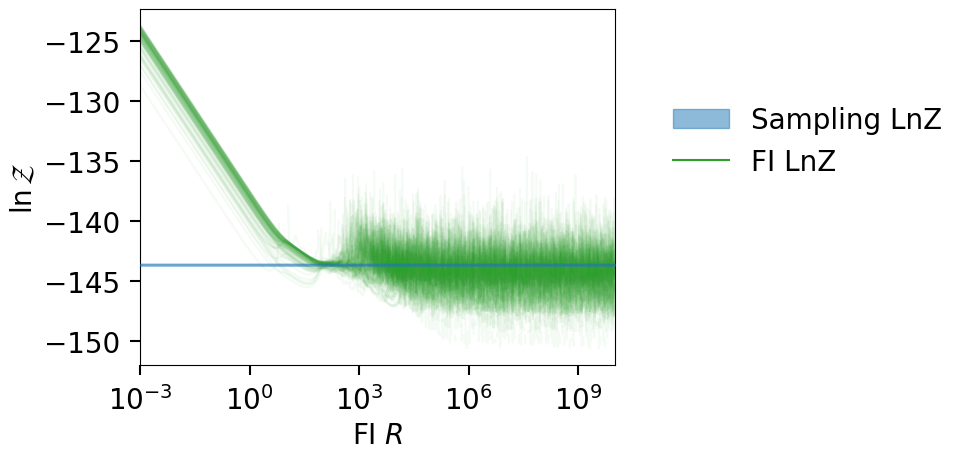

In [88]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_inividual_lnzs=True)
fig.tight_layout()